# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [22]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [23]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [24]:
recommender = MainRecommender(data_train_lvl_1)

In [25]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 871756, 844179, 1046545]

In [26]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [27]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 6552253, 15778319]

In [28]:
recommender.get_similar_users_recommendation(2375, N=5)

[974265, 10457044, 5574377, 820612, 12427353]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [29]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


##### A) Алгоритм выдавал ошибки связанные с холодным стартом для некоторых пользователей, поэтому для таких пользователей пришлось добавить в класс recommender рекомендации из top-popular по всей выборке.

In [170]:
N = 500

result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N))

K = 50

result = pd.DataFrame(columns=['algorithm', 'recall_at_k'])
result['algorithm'] = ['als_rec', 'own_rec', 'similar_items', 'similar_users']
result['recall_at_k'] = [
    result_lvl_1.apply(lambda x: recall_at_k(x['als_rec'], x['actual'], K), axis=1).mean(),
    result_lvl_1.apply(lambda x: recall_at_k(x['own_rec'], x['actual'], K), axis=1).mean(),
    result_lvl_1.apply(lambda x: recall_at_k(x['similar_items'], x['actual'], K), axis=1).mean(),
    result_lvl_1.apply(lambda x: recall_at_k(x['similar_users'], x['actual'], K), axis=1).mean()
]

result

,algorithm,recall_at_k
0,als_rec,0.047278
1,own_rec,0.065192
2,similar_items,0.033638
3,similar_users,0.002572


Наибольший recall@k получился у own recommendtions

###### B)

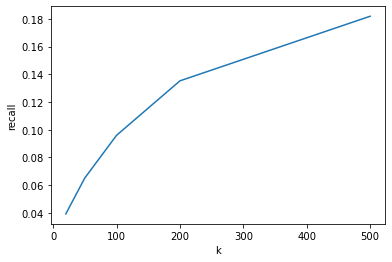

In [172]:
K = [20, 50, 100, 200, 500]
recall = []

for k in K:
    recall.append(result_lvl_1.apply(lambda x: recall_at_k(x['own_rec'], x['actual'], k), axis=1).mean())

plt.plot(K, recall)
plt.xlabel('k')
plt.ylabel('recall')
plt.show()

Видно, что чем больше k, тем больше recall. Но зависимость не прямая - на больших k значение recall растет уже не так быстро.

##### C)


Выбор нужного k должен зависеть от поставленной задачи. Если есть время и ресурсы, то можно выбирать большие значения k. В данном примере думаю, чисто технически 200 было бы достаточно, но вряд ли пользователь будет просмотривать все 200 рекомендаций.

### Задание 2.

Обучите модель 2-ого уровня, при этом:

    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    
    - Вырос ли precision@5 при использовании двухуровневой модели?

Получаем список кандидатов

In [30]:
result_lvl_2 = data_train_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2['candidates'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_2.head(2)

,user_id,actual,candidates
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


In [31]:
s = result_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
users_lvl_2 = result_lvl_2.drop(['actual', 'candidates'], axis=1).join(s)
users_lvl_2.head(4)

,user_id,item_id
0,1,856942
0,1,9297615
0,1,5577022
0,1,877391


Размечаем данные

In [32]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.head(2)

,user_id,item_id,target
0,1,856942,1.0
1,1,856942,1.0


Новые фичи

In [33]:
def featuring(data_target, data_train=None):
    # Добавляем внешние данные
    data_target = data_target.merge(item_features, on='item_id', how='left')
    data_target = data_target.merge(user_features, on='user_id', how='left')
    
    if data_train is not featuring.__defaults__[0]:
        # Средний чек пользователя
        featuring.user_mean_price = pd.DataFrame()
        featuring.user_mean_price[['user_id', 'sum_sales']] = \
            data_train.groupby(['user_id'])['sales_value'].sum().reset_index()[['user_id', 'sales_value']]
        featuring.user_mean_price['sum_quantity'] = data_train.groupby(['user_id'])['quantity'].sum().reset_index()['quantity']
        featuring.user_mean_price['user_mean_price'] = \
            featuring.user_mean_price['sum_sales'] / featuring.user_mean_price['sum_quantity']
        featuring.user_mean_price = featuring.user_mean_price.drop(['sum_sales', 'sum_quantity'], axis=1)

        # Средняя сумма покупок пользователей в разном возрасте
        featuring.user_age_sum_sales = pd.DataFrame()
        featuring.user_age_sum_sales[['age_desc', 'user_age_sum_sales']] = \
            data_train.merge(user_features, on='user_id', how='left').groupby(['age_desc'])\
            ['sales_value'].mean().reset_index()[['age_desc', 'sales_value']]
        
        # Средняя цена товара
        featuring.item_mean_price = pd.DataFrame()
        featuring.item_mean_price[['item_id', 'sum_sales']] = \
            data_train.groupby(['item_id'])['sales_value'].sum().reset_index()[['item_id', 'sales_value']]
        featuring.item_mean_price['sum_quantity'] = data_train.groupby(['item_id'])['quantity'].sum().reset_index()['quantity']
        featuring.item_mean_price['item_mean_price'] = \
            featuring.item_mean_price['sum_sales'] / featuring.item_mean_price['sum_quantity']
        featuring.item_mean_price = featuring.item_mean_price.drop(['sum_sales', 'sum_quantity'], axis=1)

        # Среднее число продаж товара
        featuring.item_mean_quantity = pd.DataFrame()
        featuring.item_mean_quantity[['item_id', 'item_mean_quantity']] = \
            data_train.groupby(['item_id'])['quantity'].mean().reset_index()[['item_id', 'quantity']]

        # Средняя сумма покупок пользователем в категории 
        featuring.user_department_mean_sales = pd.DataFrame()
        featuring.user_department_mean_sales[['user_id', 'department', 'user_department_mean_sales']] = \
            data_train.merge(item_features, on='item_id', how='left').groupby(['user_id', 'department'])\
            ['sales_value'].mean().reset_index()

        # Сумма покупок пользователем товара
        featuring.user_item_sum_sales = pd.DataFrame()
        featuring.user_item_sum_sales[['user_id', 'item_id', 'user_item_sum_sales']] = \
            data_train.groupby(['user_id', 'item_id'])['sales_value'].sum().reset_index()
    
    # Добавляем новые фичи в датасет
    data_target = data_target.merge(featuring.user_mean_price, on='user_id', how='left')
    data_target = data_target.merge(featuring.user_age_sum_sales, on='age_desc', how='left')
    data_target = data_target.merge(featuring.item_mean_price, on='item_id', how='left')
    data_target = data_target.merge(featuring.item_mean_quantity, on='item_id', how='left')
    data_target = data_target.merge(featuring.user_department_mean_sales, on=['user_id', 'department'], how='left')
    data_target = data_target.merge(featuring.user_item_sum_sales, on=['user_id', 'item_id'], how='left')
    
    return data_target

Добавляем новые фичи в датасет

In [34]:
targets_lvl_2 = featuring(targets_lvl_2, data_train_lvl_2)

Разбиваем на test и train и обучаем

In [35]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [38]:
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 
             'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 
             'household_size_desc', 'kid_category_desc']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [39]:
lgb = LGBMClassifier(objective='binary', max_depth=7, num_leaves=128)
lgb.fit(X_train, y_train)

LGBMClassifier(max_depth=7, num_leaves=128, objective='binary')

Получаем вероятности предсказаний

In [40]:
targets_lvl_2['preds'] = lgb.predict_proba(X_train)[:, 1]

Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [41]:
model2 = targets_lvl_2.sort_values(['user_id', 'preds'], ascending=False).groupby('user_id').head(5).\
groupby('user_id')['item_id'].unique().reset_index()
model2.rename(columns={'item_id': 'model2'}, inplace=True)
model2.head(2)

,user_id,model2
0,1,"[856942, 9297615, 5577022]"
1,2,"[1103898, 911974, 1076580, 5567582, 1056620]"


Находим рекомендации по первой модели

In [42]:
model1 = result_lvl_2.copy()
model1['model1'] = model1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))
model1.head(2)

,user_id,actual,candidates,model1
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212]"
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620]"


Сливаем всё в одну таблицу

In [43]:
result = model1.merge(model2, on='user_id', how='left')
result.head(2)

,user_id,actual,candidates,model1,model2
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212]","[856942, 9297615, 5577022]"
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620]","[1103898, 911974, 1076580, 5567582, 1056620]"


Вычисляем метрики на data_train_lvl_2

In [44]:
result.apply(lambda x: precision_at_k(x['model1'], x['actual'], 5), axis=1).mean()

0.17697307335190343

In [45]:
result.apply(lambda x: precision_at_k(x['model2'], x['actual'], 5), axis=1).mean()

0.5507737542556483

precision@5 для модели второго уровня вырос в 3 раза относительно модели первого уровня

А теперь делаем почти то же самое, только обучим первую модель на data_train_lvl_1 + data_train_lvl_2 и cделаем предсказание кандидатов для data_val_lvl_2. Затем полученных кандидатов ранжируем второй моделью и получим предсказания для data_val_lvl_2.

In [47]:
data_train = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)
recommender2 = MainRecommender(data_train)

In [48]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2['candidates'] = result_lvl_2['user_id'].apply(lambda x: recommender2.get_own_recommendations(x, N=50))

s = result_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = result_lvl_2.drop(['actual', 'candidates'], axis=1).join(s)
targets_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2 = featuring(targets_lvl_2)
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_mean_price,user_age_sum_sales,item_mean_price,item_mean_quantity,user_department_mean_sales,user_item_sum_sales
0,1,856942,1.0,159,GROCERY,National,BAKED BREAD/BUNS/ROLLS,FRUIT/BREAKFAST BREAD,16 OZ,65+,...,Homeowner,2 Adults No Kids,2,None/Unknown,2.309324,3.066166,2.663333,1.058824,2.406452,5.49
1,1,856942,1.0,159,GROCERY,National,BAKED BREAD/BUNS/ROLLS,FRUIT/BREAKFAST BREAD,16 OZ,65+,...,Homeowner,2 Adults No Kids,2,None/Unknown,2.309324,3.066166,2.663333,1.058824,2.406452,5.49


In [49]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']
X_train[cat_feats] = X_train[cat_feats].astype('category')

targets_lvl_2['preds'] = lgb.predict_proba(X_train)[:, 1]

model2 = targets_lvl_2.sort_values(['user_id', 'preds'], ascending=False).groupby('user_id').head(5).\
groupby('user_id')['item_id'].unique().reset_index()
model2.rename(columns={'item_id': 'model2'}, inplace=True)

model1 = result_lvl_2.copy()
model1['model1'] = model1['user_id'].apply(lambda x: recommender2.get_own_recommendations(x, N=5))

result = model1.merge(model2, on='user_id', how='left')
result.head(2)

,user_id,actual,candidates,model1,model2
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 82...","[856942, 9297615, 5577022, 877391, 9655212]","[856942, 9297615, 5577022, 877391]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 1008714, 12132312, 1075979, 998206, ...","[1092937, 1008714, 12132312, 1075979, 998206]","[12524016, 10456568, 1092502, 898763, 909811]"


In [50]:
result.apply(lambda x: precision_at_k(x['model1'], x['actual'], 5), axis=1).mean()

0.15602350636630755

In [51]:
result.apply(lambda x: precision_at_k(x['model2'], x['actual'], 5), axis=1).mean()

0.2227228207639569

На data_val_lvl_2 наблюдается та же ситуация - precision@5 для модели второго уровня вырос, но уже не так значительно как на тренировочных данных.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

**Внимание**
Позже будет добавлено требование по метрике MAP@5